In [60]:
import pandas as pd
import numpy as np
import geopandas as gdp
import shapely
import matplotlib.pyplot as plt
import os
from fiona.crs import from_epsg
from zipfile import ZipFile
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns 
from sklearn import preprocessing
%matplotlib inline

# Content: 
1. [Visualize the Cigeratte tax degree in the continental United States with smoking ratio/E-cigeratte use ratio](#Cigeratte tax degree)
2. [Investigate linear relationships between tax and smoking ratio](#linear model)
3. [Investigate the predictors for E-cigeratte use (Random Forest Model)](#Investigate the predictors)

## 1. Visualize the Cigeratte tax degree in the continental United States with smoking ratio/E-cigeratte use ratio<a class="anchor" id="Cigeratte tax degree">

### State map

Cartographic Boundary Shapefiles - States: https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html

In [6]:
#!curl http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_5m.zip > state.zip

In [7]:
states = gdp.GeoDataFrame.from_file('cb_2017_us_state_5m.shp')
states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,01,01779775,0400000US01,01,AL,Alabama,00,131174431216,4592944701,"(POLYGON ((-88.04374299999999 30.517423, -88.0..."
1,02,01785533,0400000US02,02,AK,Alaska,00,1478588231566,277723861311,"(POLYGON ((-150.242099 61.137835, -150.228774 ..."
2,04,01779777,0400000US04,04,AZ,Arizona,00,294198661567,1027245114,"POLYGON ((-114.799683 32.593621, -114.809393 3..."
3,08,01779779,0400000US08,08,CO,Colorado,00,268425964573,1178495763,"POLYGON ((-109.060253 38.599328, -109.059541 3..."
4,12,00294478,0400000US12,12,FL,Florida,00,138911437206,31398800291,"(POLYGON ((-80.751643 24.857254, -80.729063 24..."


(-1750000.0, 1750000.0)

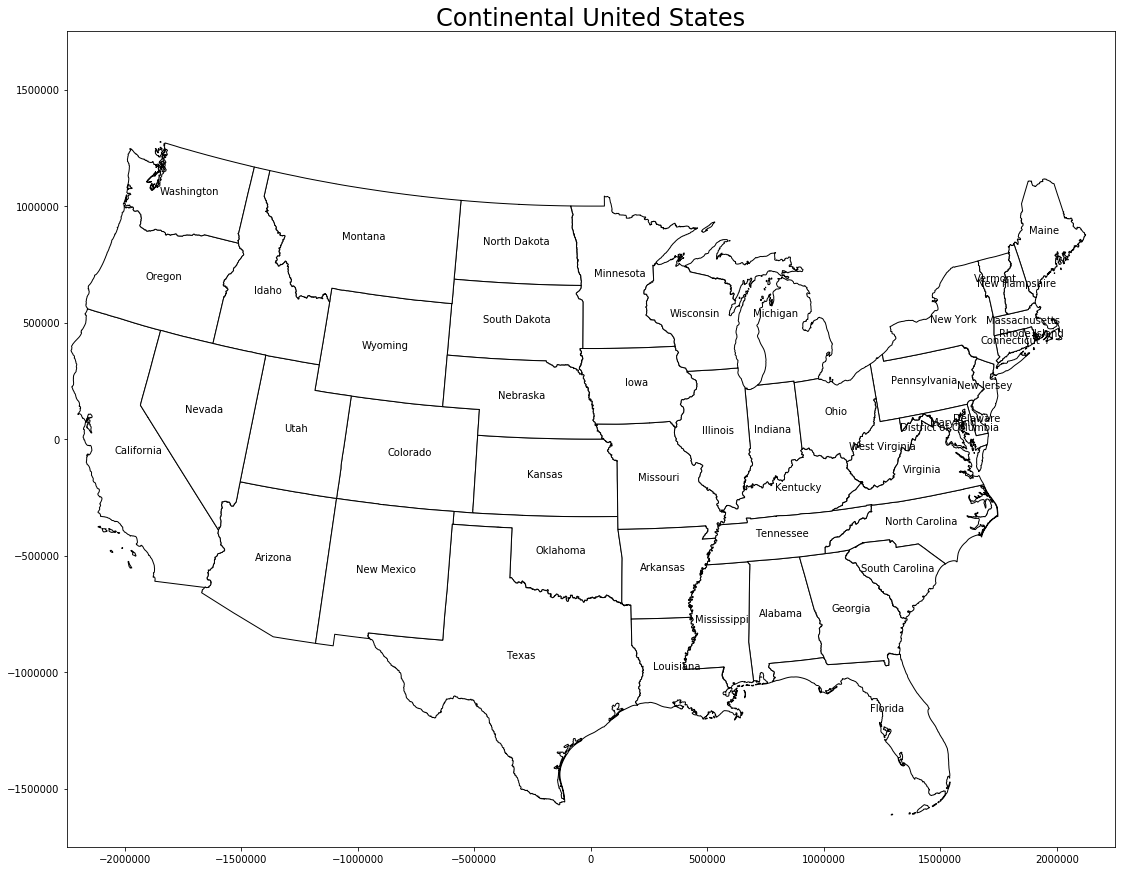

In [131]:
states.crs = from_epsg(4326)
naec = '+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'
ax = states.to_crs(naec).plot(edgecolor='black', color='white', figsize=(20,15))
states.to_crs(naec).apply(lambda state: 
                  ax.annotate(s=state.NAME, 
                              xy=state.geometry.centroid.coords[0], 
                              ha='center', clip_on=True), axis=1);
ax.set_title('Continental United States', fontsize=24)
ax.set_xlim((-2.25e6,2.25e6))
ax.set_ylim((-1.75e6,1.75e6))

**Figure 1:**The outline map of Continental United States.

### Cigeratte tax data for each state

CDC STATE System Tobacco Legislation - Tax： https://chronicdata.cdc.gov/Legislation/CDC-STATE-System-Tobacco-Legislation-Tax/2dwv-vfam

In [2]:
!curl https://chronicdata.cdc.gov/api/views/2dwv-vfam/rows.csv?accessType=DOWNLOAD > Tax.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33.5M    0 33.5M    0     0  3165k      0 --:--:--  0:00:10 --:--:-- 3495k


In [101]:
tax = pd.read_csv('Tax.csv')
tax17 = tax[tax['Year']==2017]
tax17.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Year,Quarter,LocationAbbr,LocationDesc,TopicDesc,MeasureDesc,DataSource,ProvisionGroupDesc,ProvisionDesc,ProvisionValue,...,Comments,Enacted_Date,Effective_Date,GeoLocation,DisplayOrder,TopicTypeId,TopicId,MeasureId,ProvisionGroupID,ProvisionID
120339,2017,1,MN,Minnesota,Legislation - Tax Combustible Tobacco,Little Cigar,OSH,Restrictions,Little Cigar Tax ($ per pack of 20),3.0400,...,NaN,10/31/2016,1/1/2017,"(46.35564873600049, -94.79420050299967)",2,LEG,1010LEG,672LCG,10GRP,417
121546,2017,2,CA,California,Legislation - Tax Combustible Tobacco,Little Cigar,OSH,Restrictions,Little Cigar Tax ($ per pack of 20),2.8700,...,Currently products labeled as little or small ...,10/31/2016,4/1/2017,"(37.63864012300047, -120.99999953799971)",2,LEG,1010LEG,672LCG,10GRP,417
121547,2017,2,CA,California,Legislation - Tax Combustible Tobacco,Cigarette,OSH,Restrictions,Cigarette Tax ($ per pack),2.870,...,NaN,10/31/2016,4/1/2017,"(37.63864012300047, -120.99999953799971)",5,LEG,1010LEG,670CGR,10GRP,411
121548,2017,1,MI,Michigan,Legislation - Tax Stamp,Tax Stamp,OSH,Requirements,Barcode/Scannable Code Required,Yes,...,NaN,6/20/2012,6/20/2012,"(44.6613195430005, -84.71439026999968)",2,LEG,1030LEG,690CET,12GRP,350
121549,2017,1,RI,Rhode Island,Legislation - Tax Non-Combustible Tobacco,Dry Snuff Tobacco,OSH,Restrictions,Dry Snuff Tobacco Tax,Yes,...,NaN,1/1/1995,1/1/1995,"(41.70828019300046, -71.52247031399963)",1,LEG,1020LEG,682EDS,10GRP,392


In [32]:
tax_value.shape

(58, 1)

In [153]:
tax_value = tax17[tax17['ProvisionDesc'] == 'Cigarette Tax ($ per pack)'].sort_values('LocationDesc')
tax_value = tax_value.groupby('LocationDesc').max()
tax_value = tax_value[['ProvisionAltValue']]
tax_value.rename(columns={'ProvisionAltValue':'cigarette_tax'}, inplace=True)
tax_value.head()

,cigarette_tax
LocationDesc,
Alabama,0.675
Alaska,2.000
American Samoa,6.000
Arizona,2.000
Arkansas,1.150


### Plot tax information in each state

In [156]:
tax_state = gdp.GeoDataFrame(pd.merge(states, tax_value, left_on='NAME', right_index='LocationDesc'))

(-1750000.0, 1750000.0)

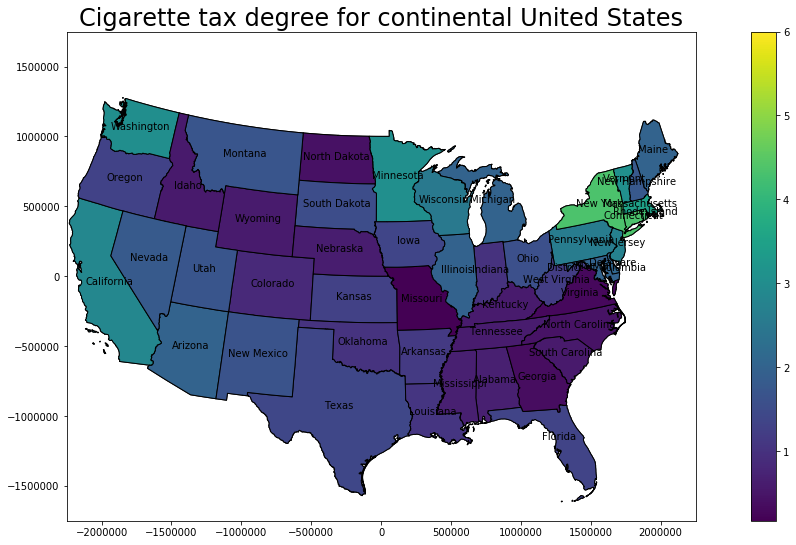

In [246]:
tax_state.crs = from_epsg(4326)
naec = '+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'
ax = tax_state.to_crs(naec).plot(edgecolor='black', color='white', figsize=(20,9))
tax_state.to_crs(naec).plot(column='Cigarette_tax', edgecolor='black', cmap='viridis',
                              legend=True, ax=ax)
tax_state.to_crs(naec).apply(lambda state: 
                  ax.annotate(s=state.NAME, 
                              xy=state.geometry.centroid.coords[0], 
                              ha='center', clip_on=True), axis=1);
ax.set_title('Cigarette tax degree for continental United States', fontsize=24)
ax.set_xlim((-2.25e6,2.25e6))
ax.set_ylim((-1.75e6,1.75e6))

**Figure 2**: Each state has different digree of Cigarette tax. The states which locate at the middle and the left bottom part of U.S. tend to have lower tax, while the east coast and west coast tend to have higher tax rate, some big cities such as New York, California, Washington tend to have the highest tax. These may can be related with the economy condition in that states. 

### Visualize the number of people smoking/using E-cigeratte with the tax rate <a class="anchor" id="Visualize the number of people smoking">

2017 BRFSS Survey Data and Documentation
https://www.cdc.gov/brfss/annual_data/annual_2017.html

In [5]:
!curl https://www.cdc.gov/brfss/annual_data/2017/files/LLCP2017XPT.zip > healthdata17.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  101M  100  101M    0     0  57.0M      0  0:00:01  0:00:01 --:--:-- 57.0M0M    0     0  59.6M      0  0:00:01  0:00:01 --:--:-- 59.6M


In [6]:
!mv healthdata17.zip $PUIDATA

In [7]:
healthdata = ZipFile(os.getenv('PUIDATA') + ('/healthdata17.zip'))
healthdata.extractall(os.getenv('PUIDATA'))

In [11]:
healthdata = pd.read_sas(os.getenv('PUIDATA') + '/LLCP2017.XPT')

In [12]:
statename = pd.read_excel('statecode_value.xlsx')
statename.head()

,value,state_name
0,1,Alabama
1,2,Alaska
2,4,Arizona
3,5,Arkansas
4,6,California


In [13]:
healthdata = pd.merge(statename, healthdata, left_on='value', right_on='_STATE')
healthdata.head(5)

,value,state_name,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,...,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_PASTAE1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
0,1,Alabama,1.0,1.0,b'01302017',b'01',b'30',b'2017',1100.0,b'2017000001',...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1,Alabama,1.0,1.0,b'01122017',b'01',b'12',b'2017',1100.0,b'2017000002',...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1,Alabama,1.0,1.0,b'01102017',b'01',b'10',b'2017',1100.0,b'2017000003',...,3.0,2.0,2.0,4.0,2.0,1.0,1.0,1.0,1.0,2.0
3,1,Alabama,1.0,1.0,b'02082017',b'02',b'08',b'2017',1200.0,b'2017000004',...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,NaN
4,1,Alabama,1.0,1.0,b'01302017',b'01',b'30',b'2017',1100.0,b'2017000005',...,3.0,2.0,2.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0


In [56]:
healthdata.shape

(450016, 360)

SAS | Label  Meaning

_RFSMOK3: Current Smoking Calculated Variable
        * 1: No
        * 2: Yes
        * 3: Don’t know/Refused/Missing
        
_CURECIG: Current E-cigarette User Calculated Variable
        * 1: No
        * 2: Yes
        * 3: Don’t know/Refused/Missing
        

In [107]:
smoke = healthdata[['state_name', '_STATE', '_RFSMOK3', '_CURECIG']].rename(
    columns={'_STATE':'state', '_RFSMOK3':'smoke_status', '_CURECIG':'E_cigarette'})

In [108]:
smoke.head()

,state_name,state,smoke_status,E_cigarette
0,Alabama,1.0,1.0,1.0
1,Alabama,1.0,1.0,1.0
2,Alabama,1.0,1.0,1.0
3,Alabama,1.0,1.0,1.0
4,Alabama,1.0,1.0,1.0


In [109]:
df = smoke[smoke['state']==1]
df.groupby('E_cigarette').count()

,state_name,state,smoke_status
E_cigarette,,,
1.0,6215,6215,6215
2.0,226,226,226
9.0,313,313,313


In [110]:
ratio = []
for i in statename['value']:
    df = smoke[smoke['state']==i]
    smoke_ratio = df.groupby('smoke_status').count()['state_name'][2]/len(df)
    e_ratio = df.groupby('E_cigarette').count()['state_name'][2]/len(df)
    ratio.append([i, smoke_ratio, e_ratio])
ratio_df = pd.DataFrame(ratio).rename(columns={0:'value', 1:'smoke_ratio', 2:'e_cig_ratio'})
ratio_df.head()

,value,smoke_ratio,e_cig_ratio
0,1,0.169233,0.033462
1,2,0.168280,0.021230
2,4,0.127557,0.035099
3,5,0.152011,0.026494
4,6,0.101945,0.028639


In [157]:
tax_state['GEOID'] = tax_state['GEOID'].astype(int)
smoke_tax = pd.merge(tax_state, ratio_df, left_on='GEOID', right_on='value')
smoke_tax.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,cigarette_tax,value,smoke_ratio,e_cig_ratio
0,01,01779775,0400000US01,1,AL,Alabama,00,131174431216,4592944701,"(POLYGON ((-88.04374299999999 30.517423, -88.0...",0.675,1,0.169233,0.033462
1,02,01785533,0400000US02,2,AK,Alaska,00,1478588231566,277723861311,"(POLYGON ((-150.242099 61.137835, -150.228774 ...",2.000,2,0.168280,0.021230
2,04,01779777,0400000US04,4,AZ,Arizona,00,294198661567,1027245114,"POLYGON ((-114.799683 32.593621, -114.809393 3...",2.000,4,0.127557,0.035099
3,08,01779779,0400000US08,8,CO,Colorado,00,268425964573,1178495763,"POLYGON ((-109.060253 38.599328, -109.059541 3...",0.840,8,0.113548,0.033156
4,12,00294478,0400000US12,12,FL,Florida,00,138911437206,31398800291,"(POLYGON ((-80.751643 24.857254, -80.729063 24...",1.339,12,0.170135,0.040120


In [112]:
ratio = ratio_df.copy()
ratio['geometry'] = smoke_tax['geometry'].centroid
ratio = gdp.GeoDataFrame(ratio)
ratio['smoke_ratio'].astype(float)
ratio.head()

,value,smoke_ratio,e_cig_ratio,geometry
0,1,0.169233,0.033462,POINT (-86.82856727863843 32.78871085643127)
1,2,0.168280,0.021230,POINT (-152.2112567184516 64.19854169796452)
2,4,0.127557,0.035099,POINT (-111.6646390712508 34.29321115005885)
3,5,0.152011,0.026494,POINT (-105.5478146961501 38.99854551511102)
4,6,0.101945,0.028639,POINT (-82.49771957500626 28.620313423768)


(-1750000.0, 1750000.0)

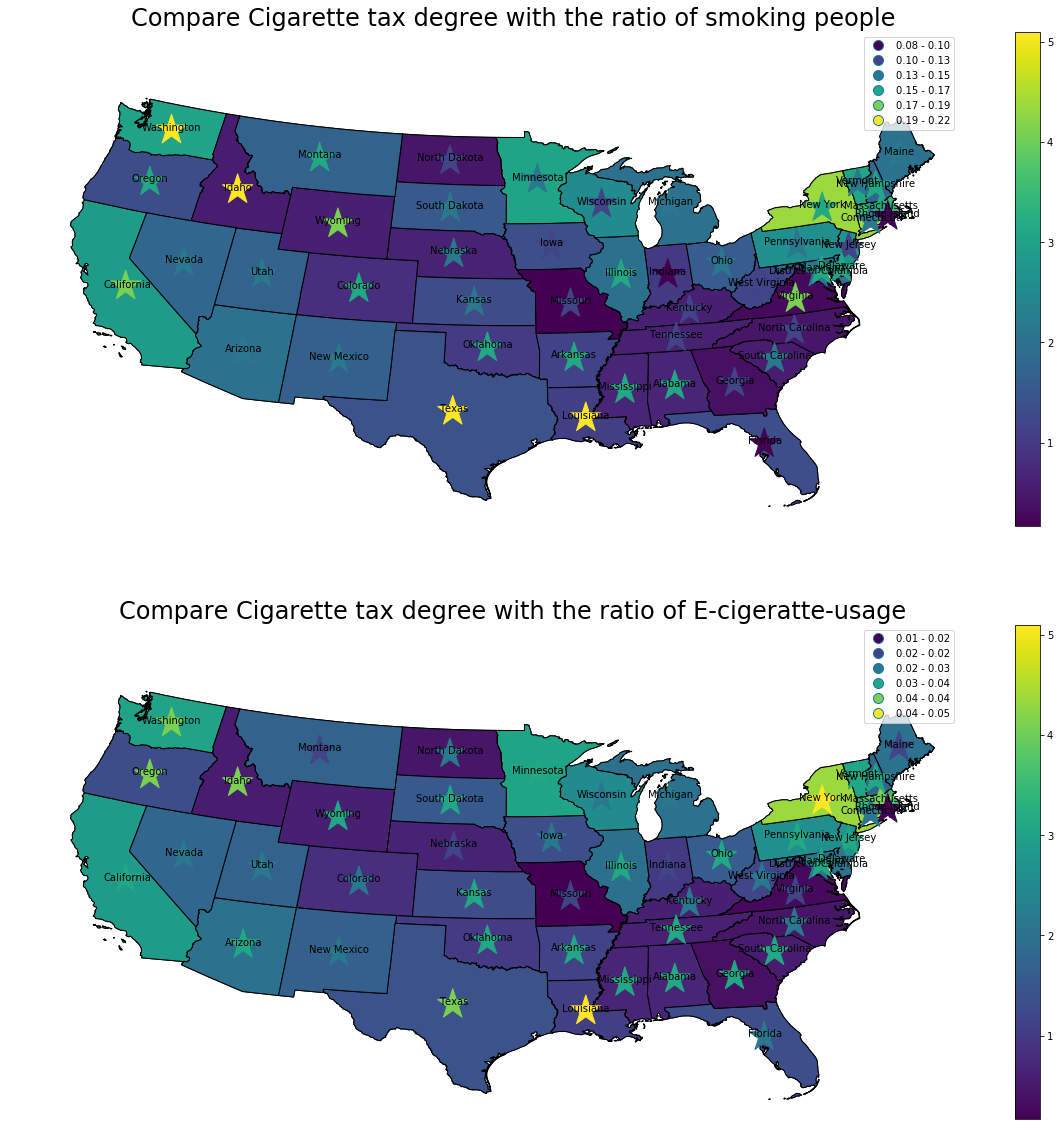

In [238]:
smoke_tax.crs = from_epsg(4326)
ratio.crs = from_epsg(4326)
naec = '+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'
#plot the tax degree and smoking-rato:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(211)
ax1.axis('off')
smoke_tax.to_crs(naec).plot(edgecolor='black', color='white', figsize=(20,15), ax=ax1)
smoke_tax.to_crs(naec).plot(column='Cigarette_tax', edgecolor='black', k=10, cmap='viridis',
                              legend=True, ax=ax1)
ratio.to_crs(naec).plot(column='smoke_ratio', cmap='viridis', 
                        legend=True, ax=ax1, marker='*', markersize=1000, k=6, scheme='equal_interval')
smoke_tax.to_crs(naec).apply(lambda state: 
                  ax1.annotate(s=state.NAME, 
                              xy=state.geometry.centroid.coords[0], 
                              ha='center', clip_on=True), axis=1);
ax1.set_title('Compare Cigarette tax degree with the ratio of smoking people', fontsize=24)
ax1.set_xlim((-2.25e6,2.25e6))
ax1.set_ylim((-1.75e6,1.75e6))

#plot the tax degree and E-cigeratte using:
ax2 = fig.add_subplot(212)
ax2.axis('off')
smoke_tax.to_crs(naec).plot(edgecolor='black', color='white', figsize=(20,15), ax=ax2)
smoke_tax.to_crs(naec).plot(column='Cigarette_tax', edgecolor='black', k=10, cmap='viridis',
                              legend=True, ax=ax2)
ratio.to_crs(naec).plot(column='e_cig_ratio', cmap='viridis', 
                        legend=True, ax=ax2, marker='*', markersize=1000, k=6, scheme='equal_interval')
smoke_tax.to_crs(naec).apply(lambda state: 
                  ax2.annotate(s=state.NAME, 
                              xy=state.geometry.centroid.coords[0], 
                              ha='center', clip_on=True), axis=1);
ax2.set_title('Compare Cigarette tax degree with the ratio of E-cigeratte-usage', fontsize=24)
ax2.set_xlim((-2.25e6,2.25e6))
ax2.set_ylim((-1.75e6,1.75e6))

**Figure 3:** The top figure aim at detecting the relationship between the cigeratte tax rate and smoking rate (shown as the ratio of how many people current smoke); while the bottom figure aim at detecting the relationship between the cigeratte tax rate and E-cigeratte usage rate (shown as the ratio of how many people current use E-cigeratte). The background is the degree of tax indicated by the Choropleths; while the marker "*" is the ratio indicated by the scheme. From the 1st graph, the higher ratio of smoking tend to show in the area where the tax is lower. While the relationship can't be conversed since some area has low tax rate but also has low smoking rate, which may because economy factors or personal factors. The interesting thing is that although some strong states such as New York, California and Washinton have top tax rate but their smoking ratio are still high. **Therefore, the relationship between tax and smoking rate can be further detected.** From the 2nd graph, the Cigeratte tax seems have little impact on the using of E-scigarette. New York also be the state that has highest E-cigeratte usage rate. **Therefore, other factors that influence the people whether taking E-cigeratte can be further researched.**

## 2. investigate linear relationships between tax and smoking ratio <a class="anchor" id="linear model">

Change both quantities to the same order of magnitude (unity) by dividing by the order of magnitude of the mean of the sample

In [127]:
smoke_tax.Cigarette_tax.mean()

1.8125283018867921

In [128]:
smoke_tax.smoke_ratio.mean()

0.14433635009749021

In [149]:
x = smoke_tax.Cigarette_tax
y = smoke_tax.smoke_ratio

In [147]:
#def standardize(series):
    series = (series-series.mean())/series.std()
    return series
#x = standardize(smoke_tax.Cigarette_tax)
#y = standardize(smoke_tax.smoke_ratio)

In [158]:
smoke_tax.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,cigarette_tax,value,smoke_ratio,e_cig_ratio
0,01,01779775,0400000US01,1,AL,Alabama,00,131174431216,4592944701,"(POLYGON ((-88.04374299999999 30.517423, -88.0...",0.675,1,0.169233,0.033462
1,02,01785533,0400000US02,2,AK,Alaska,00,1478588231566,277723861311,"(POLYGON ((-150.242099 61.137835, -150.228774 ...",2.000,2,0.168280,0.021230
2,04,01779777,0400000US04,4,AZ,Arizona,00,294198661567,1027245114,"POLYGON ((-114.799683 32.593621, -114.809393 3...",2.000,4,0.127557,0.035099
3,08,01779779,0400000US08,8,CO,Colorado,00,268425964573,1178495763,"POLYGON ((-109.060253 38.599328, -109.059541 3...",0.840,8,0.113548,0.033156
4,12,00294478,0400000US12,12,FL,Florida,00,138911437206,31398800291,"(POLYGON ((-80.751643 24.857254, -80.729063 24...",1.339,12,0.170135,0.040120


In [197]:
model = smoke_tax[['cigarette_tax', 'smoke_ratio']]#.rename(columns={'cigarette_tax':'X', 'smoke_ratio':'Y'}).sort('X')
model.head()

,cigarette_tax,smoke_ratio
0,0.675,0.169233
1,2.000,0.168280
2,2.000,0.127557
3,0.840,0.113548
4,1.339,0.170135


In [434]:
mod = smf.ols('smoke_ratio ~ cigarette_tax', data=smoke_tax).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            smoke_ratio   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     12.77
Date:                Sat, 08 Dec 2018   Prob (F-statistic):           0.000779
Time:                        08:51:33   Log-Likelihood:                 117.96
No. Observations:                  53   AIC:                            -231.9
Df Residuals:                      51   BIC:                            -228.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         0.1647      0.007     24.344      0.000         0.151     0.178
cigarette_tax    -0.0112      0.003     -3.574      0.001        -0.018    -0.005
==============================================================================
Omnibus:                        8.520   Durbin-Watson:                   2.297
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.794
Skew:                           0.664   Prob(JB):                       0.0123
Kurtosis:                       4.490   Cond. No.                         4.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5,1,'Smoking ratio aganist Cigarette tax linear model (with confidence interval)')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


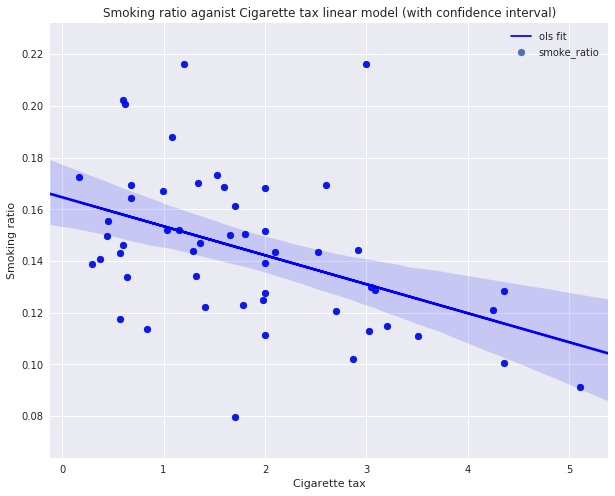

In [498]:
plt.figure(figsize=(10,8))
plt.scatter(smoke_tax.cigarette_tax, smoke_tax.smoke_ratio)
plt.plot(smoke_tax.cigarette_tax, mod.predict(), color='blue', label='ols fit')
sns.regplot(x="cigarette_tax", y="smoke_ratio", data=smoke_tax, color='blue')
plt.legend()
plt.xlabel('Cigarette tax')
plt.ylabel('Smoking ratio')
plt.title('Smoking ratio aganist Cigarette tax linear model (with confidence interval)')

**Figure 4:** The ols-linear  regression report and the fitted line. The cigarette tax has a statistically significant effect on the smoking ratio, which can also be seen in the fitted line. However,  the R-square is just 0.2, indicating this is not a good model in fitness. 

## 3. Investigate the predictors for E-cigeratte use <a class="anchor" id="Investigate the predictors">

In [15]:
factors = healthdata[['_CURECIG', 'SEX', '_AGEG5YR', '_INCOMG', 'EDUCA', '_RACEGR3', '_RFSMOK3', 
        'EXERANY2', 'CHECKUP1', '_BMI5CAT', 'TOLDHI2', 'CHCCOPD1', 'ASTHMA3', '_RFHYPE5']].rename(columns=
        {'_CURECIG':'E-USE', '_AGEG5YR':'AGE', '_INCOMG':'INCOME', 'EDUCA':'EDUCATION', 
         '_RACEGR3':'RACE', '_RFSMOK3':'SMOKE_STATUS', 'CHECKUP1':'HEALTH_CHECK', 
         'EXERANY2':'EXERCISE', '_BMI5CAT':'BMI', 'TOLDHI2':'CHOLESTEROL', 'CHCCOPD1':'PULONARY', 
         'ASTHMA3':'ASTHMA', '_RFHYPE5':'BlOODP'})
factors.head()

,E-USE,SEX,AGE,INCOME,EDUCATION,RACE,SMOKE_STATUS,EXERCISE,HEALTH_CHECK,BMI,CHOLESTEROL,PULONARY,ASTHMA,BlOODP
0,1.0,2.0,11.0,4.0,6.0,1.0,1.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0
1,1.0,1.0,10.0,5.0,6.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0
2,1.0,1.0,11.0,9.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,2.0,2.0,1.0
3,1.0,2.0,11.0,1.0,3.0,1.0,1.0,NaN,1.0,3.0,1.0,1.0,2.0,2.0
4,1.0,2.0,10.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0


In [16]:
factors.shape

(450016, 14)

In [17]:
#detect the imbalance issue:
print('The original class size for e-cigarette use:')
print(factors['E-USE'].value_counts())
print('Class size after fixing imbalance and droping missing value:')
use_2 = factors[factors['E-USE']==2]
use_1 = factors[factors['E-USE']==1].sample(n=len(use_2),replace=True)
factorsfix = pd.concat([use_1, use_2])
print(factorsfix['E-USE'].value_counts())

The original class size for e-cigarette use:
1.0    415693
9.0     20646
2.0     13677
Name: E-USE, dtype: int64
Class size after fixing imbalance and droping missing value:
2.0    13677
1.0    13677
Name: E-USE, dtype: int64


**Interpretation**: The bottom graph is the results of addressing class imbalance problem. 13677 observations were randomly chosen from the original 415693 observation in class 2, while the new class is still large enough for analysis.  

In [18]:
factorsfix.head()

,E-USE,SEX,AGE,INCOME,EDUCATION,RACE,SMOKE_STATUS,EXERCISE,HEALTH_CHECK,BMI,CHOLESTEROL,PULONARY,ASTHMA,BlOODP
417372,1.0,2.0,7.0,5.0,5.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,2.0,1.0
292317,1.0,2.0,12.0,5.0,6.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0
267095,1.0,1.0,5.0,3.0,3.0,5.0,2.0,2.0,4.0,3.0,2.0,2.0,2.0,1.0
262012,1.0,2.0,11.0,5.0,6.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0
368128,1.0,2.0,8.0,5.0,6.0,1.0,1.0,2.0,1.0,NaN,2.0,2.0,2.0,2.0


In [221]:
#e_use = healthdata[['_CURECIG']].rename(columns={'_CURECIG':'E-USE'})
#e_use = e_use[e_use['E-USE']<9].dropna()

In [40]:
#demographic factors
demog = factorsfix[['E-USE', 'SEX', 'AGE', 'INCOME', 'EDUCATION', 'RACE']]
demog = demog[(demog['E-USE']<9)&(demog['SEX']<9)&(demog['AGE']<14)&(demog['INCOME']<9)
              &(demog['EDUCATION']<9)&(demog['RACE']<9)].dropna()

In [41]:
#factors about health conciousness
concious = factorsfix[['E-USE', 'SMOKE_STATUS', 'EXERCISE', 'HEALTH_CHECK', 'BMI']]
concious = concious[(concious['E-USE']<9)&(concious['SMOKE_STATUS']<9)&(concious['HEALTH_CHECK']<7)&
                                  (concious['EXERCISE']<7)& (concious['BMI']<5)].dropna()

In [42]:
#factors about diseases
diseases = factorsfix[['E-USE','CHOLESTEROL', 'PULONARY', 'ASTHMA', 'BlOODP']]
diseases = diseases[(diseases['E-USE']<9)&(diseases['CHOLESTEROL']<7)&(diseases['PULONARY']<7)
                    &(diseases['ASTHMA']<7)&(diseases['BlOODP']<9)].dropna()

#### Demographic factors to predict E-smoker

In [45]:
def RandonForest(df):
    
    #train-test split, and standardize the data:
    Y = df[['E-USE']]
    X = df.drop(['E-USE'], axis=1)
    X = pd.DataFrame(preprocessing.scale(X), columns=X.columns)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=100)
    print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
    
    #fit Random Forest and test the accuracy:
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, Y_train)   
    Y_pred = rf.predict(X_test)
    cm = confusion_matrix(Y_test, Y_pred)
    #RFcm = cm
    MSE = mean_squared_error(Y_test, Y_pred)
    ACC = (cm[0][0] + cm[1][1]) / (len(Y_pred))
    importance = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf.feature_importances_,3)})
    importance = importance.sort_values('importance',ascending=False).set_index('feature')

    print('The confusion matrix is:')
    print(cm)
    print('The Accuracy Rate is', ACC)
    print('The Mean Squared Error is:', MSE)
    print('-----------------------------------------------------')
    print('The Classification Report is:')
    print(classification_report(Y_test, Y_pred))
    print('-----------------------------------------------------')
    print('The Feature Importance is:')
    print(importance)

In [46]:
np.random.seed(1997)
RandonForest(demog)

(15296, 5) (7535, 5) (15296, 1) (7535, 1)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


The confusion matrix is:
[[2427 1295]
 [1134 2679]]
The Accuracy Rate is 0.677637690776
The Mean Squared Error is: 0.322362309224
-----------------------------------------------------
The Classification Report is:
             precision    recall  f1-score   support

        1.0       0.68      0.65      0.67      3722
        2.0       0.67      0.70      0.69      3813

avg / total       0.68      0.68      0.68      7535

-----------------------------------------------------
The Feature Importance is:
           importance
feature              
AGE             0.511
EDUCATION       0.188
INCOME          0.135
RACE            0.126
SEX             0.040


**Interpretation**: Choose the age for the final prediction model.

#### Health conciousness factors to predict E-smoker

In [47]:
RandonForest(concious)

(16321, 4) (8039, 4) (16321, 1) (8039, 1)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


The confusion matrix is:
[[3359  688]
 [1687 2305]]
The Accuracy Rate is 0.704565244433
The Mean Squared Error is: 0.295434755567
-----------------------------------------------------
The Classification Report is:
             precision    recall  f1-score   support

        1.0       0.67      0.83      0.74      4047
        2.0       0.77      0.58      0.66      3992

avg / total       0.72      0.70      0.70      8039

-----------------------------------------------------
The Feature Importance is:
              importance
feature                 
SMOKE_STATUS       0.873
HEALTH_CHECK       0.097
BMI                0.023
EXERCISE           0.007


**Interpretation**: Choose the smoke status for the final prediction model.

#### Diseases factors to predict E-smoker

In [48]:
RandonForest(diseases)

(16192, 4) (7976, 4) (16192, 1) (7976, 1)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


The confusion matrix is:
[[3676  535]
 [2799  966]]
The Accuracy Rate is 0.581995987964
The Mean Squared Error is: 0.418004012036
-----------------------------------------------------
The Classification Report is:
             precision    recall  f1-score   support

        1.0       0.57      0.87      0.69      4211
        2.0       0.64      0.26      0.37      3765

avg / total       0.60      0.58      0.54      7976

-----------------------------------------------------
The Feature Importance is:
             importance
feature                
PULONARY          0.471
BlOODP            0.218
CHOLESTEROL       0.168
ASTHMA            0.142


**Interpretation**: Choose the PULONARY and BlOODP for the final prediction model.

#### Pick the relatively important features from the above models:

In [56]:
features = factorsfix[['E-USE', 'AGE', 'EDUCATION', 'SMOKE_STATUS', 'PULONARY', 'BlOODP']] #

features = features[(features['E-USE']<9)&(features['AGE']<14)& (features['EDUCATION']<9)&
                      (features['SMOKE_STATUS']<9)&(features['PULONARY']<7)&
                      (features['BlOODP']<9)].dropna() 

In [57]:
RandonForest(features)


(17866, 5) (8801, 5) (17866, 1) (8801, 1)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


The confusion matrix is:
[[3271 1160]
 [1008 3362]]
The Accuracy Rate is 0.753664356323
The Mean Squared Error is: 0.246335643677
-----------------------------------------------------
The Classification Report is:
             precision    recall  f1-score   support

        1.0       0.76      0.74      0.75      4431
        2.0       0.74      0.77      0.76      4370

avg / total       0.75      0.75      0.75      8801

-----------------------------------------------------
The Feature Importance is:
              importance
feature                 
SMOKE_STATUS       0.424
AGE                0.397
EDUCATION          0.117
PULONARY           0.042
BlOODP             0.020


**Interpretation**: The final prediction model. All variables were chosen from the previous three sub-models based on their importance ratio to that model. The accuracy rate in this model is around 75%, which was not bad (especially compared to the previous three models). The results indicated that the current smoking status and age are the most important feature, accounted for around 80% importance.